In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras import backend as K

In [2]:
cols = 275
rows = 183

In [3]:
def get_image_tensor(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(cols, rows))
    img_to_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    processed_image = tf.keras.applications.vgg16.preprocess_input(img_to_tensor)    
    return processed_image

In [4]:
base_image = get_image_tensor("data/base.jpg")
style_image = get_image_tensor("data/style.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


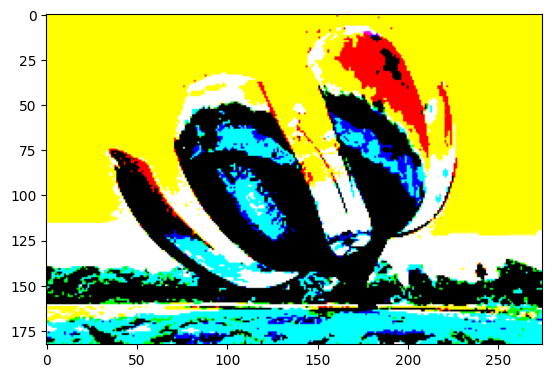

In [5]:
plt.imshow(base_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


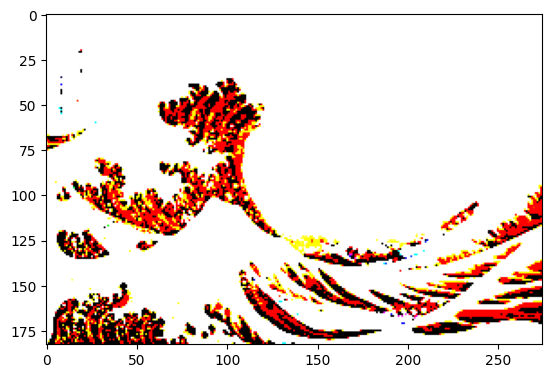

In [6]:
plt.imshow(style_image)

In [7]:
pre_trained_model = vgg19.VGG19(weights="imagenet", include_top=False)
for layer in pre_trained_model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [8]:
content_layer = "block4_conv2"
style_layers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]

In [9]:
class neural_transfer_model(tf.keras.Model):       
    def __init__(self,pre_trained_model,content_layers,style_layers,content_weight,style_weight):
        super().__init__()     
        self.pre_trained_model = pre_trained_model
        self.white_image = tf.Variable(tf.ones(shape = (1,rows,cols,3)))       
        
        self.content_layer = self.pre_trained_model.get_layer(content_layers).output
        self.style_layer = [self.pre_trained_model.get_layer(layer).output for layer in style_layers]        
        
        self.content_model = Model(inputs = self.pre_trained_model.inputs, outputs = self.content_layer)
        self.style_model = Model(inputs = self.pre_trained_model.inputs, outputs = self.style_layer)
        
        self.content_weight = content_weight
        self.style_weight = style_weight
       
    
    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer   
        
    def gram_matrix(self,x):  #Detailed in notebook style_Loss
        features = K.batch_flatten(K.permute_dimensions(x[0],(2,0,1)))
        gram = K.dot(features,K.transpose(features))
        return gram

    def style_loss(self,style,white_image):    #Detailed in notebook style_Loss
        S = self.gram_matrix(style)
        C = self.gram_matrix(white_image)
        channels = 3
        size = rows * cols
        return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))   
    
    def content_loss(self,image):    #Detailed in notebook content_Loss
        base_pred = self.content_model(image)     
        white_pred = self.content_model(self.white_image)         
        return tf.reduce_sum(tf.square(white_pred - base_pred))
    
        
    def train_step(self, data):                
        
        content_data = data[0][0]
        style_data = data[0][1]
        
        with tf.GradientTape() as tape:      
            
            s_loss = tf.zeros(shape=())      
            
            style_fowards = self.style_model(style_data)
            style_white_noise_fowards = self.style_model(self.white_image)  
            
            for i in range(len(style_fowards)):    
                sl = self.style_loss(style_fowards[i],style_white_noise_fowards[i])                    
                s_loss += (1 / len(style_fowards)) * sl              
                
            c_loss = self.content_loss(content_data)
            
            total_loss = self.content_weight * c_loss + self.style_weight * s_loss 
                
        grads = tape.gradient(total_loss, [self.white_image])[0]            
        self.optimizer.apply_gradients([(grads, self.white_image)])  
        return {"total_loss": total_loss,"style_loss": s_loss,"content_loss": c_loss}

In [10]:
model = neural_transfer_model(pre_trained_model = pre_trained_model,content_layers = content_layer,style_layers = style_layers,content_weight = 1 ,style_weight = 10)

In [11]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.00001))

In [12]:
x_train = (np.expand_dims(base_image,axis = 0),np.expand_dims(style_image,axis = 0))

In [13]:
model.fit(x = x_train,epochs = 4000)

Epoch 1/4000
1/1 [==============================] - 4s 4s/step - total_loss: 911200616448.0000 - style_loss: 65978261504.0000 - content_loss: 251417985024.0000
Epoch 2/4000
1/1 [==============================] - 0s 37ms/step - total_loss: 903491747840.0000 - style_loss: 65711054848.0000 - content_loss: 246381182976.0000
Epoch 3/4000
1/1 [==============================] - 0s 36ms/step - total_loss: 886201647104.0000 - style_loss: 64857923584.0000 - content_loss: 237622362112.0000
Epoch 4/4000
1/1 [==============================] - 0s 36ms/step - total_loss: 833352892416.0000 - style_loss: 61127249920.0000 - content_loss: 222080368640.0000
Epoch 5/4000
1/1 [==============================] - 0s 35ms/step - total_loss: 668220260352.0000 - style_loss: 45426847744.0000 - content_loss: 213951741952.0000
Epoch 6/4000
1/1 [==============================] - 0s 36ms/step - total_loss: 659609223168.0000 - style_loss: 40444657664.0000 - content_loss: 255162613760.0000
Epoch 7/4000
1/1 [============

In [14]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((rows, cols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [15]:
result = deprocess_image(model.white_image[0].numpy())

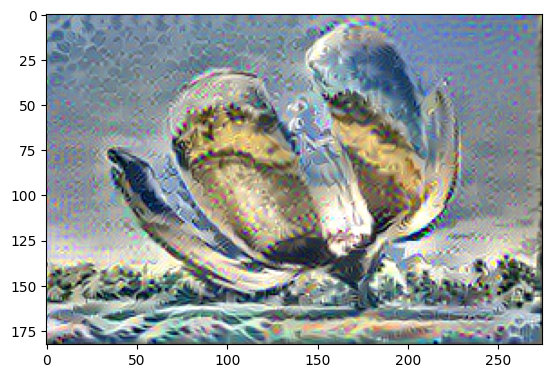

In [16]:
plt.imshow(result)